In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# A2e-MMC tools repository: https://github.com/a2e-mmc/mmctools/tree/dev
from mmctools.helper_functions import calc_wind, estimate_ABL_height
from mmctools.plotting import plot_timehistory_at_height, plot_profile

# NREL windtools repository for SOWFA-specific postprocessing: https://github.com/NREL/windtools
from windtools.SOWFA6.postProcessing.averaging import PlanarAverages

# Estimate ABL height from SOWFA planar averages (for Figure 3)
written by [Eliot Quon](mailto:eliot.quon@nrel.gov)

The ABL height is determined as a hybrid of two approaches:
1. The minima in vertical kinematic heat flux (i.e., the middle of the entrainment zone), for convective conditions
2. The height at which the horizontal shear stress is linearly extrapolated to zero, for stable conditions (e.g., see Kosovic & Curry 2000).

Where the detected "convective" boundary layer height $\to 0$, i.e., is below a specified `blendheight`, the height of the boundary layer switches to the detected stable height based on shear stress.

In [3]:
# ad-hoc value for switching between the calculated convective/stable boundary layer heights
blendheight = 150.

In [4]:
# data information
simstart = '2013-11-08'
datadir = '/projects/mmc/dallaert/profile_assimilation_wrf/'
cases = {
    'WRF mesoscale budget': 'run.tency',
    'MMC direct assimilation': 'run.assim',
    'MMC indirect assimilation (linear fit)': 'run.reg.M1',
    'MMC indirect assimilation (cubic fit)': 'run.reg.W.none.Fw0',
}

In [5]:
# plotting parameters
styles = {
    'MMC direct assimilation': {'linestyle':'--','color':'#2ca02c','linewidth':2},
    'WRF mesoscale budget': {'linestyle':'-','color':'#9467bd','linewidth':2},
    'MMC indirect assimilation (cubic fit)': {'linestyle':'-','color':'#d62728','linewidth':2},
    'MMC indirect assimilation (linear fit)': {'linestyle':'-','color':'#8c564b','linewidth':2},
}

In [6]:
# LOCAL times, from https://www.timeanddate.com/sun/usa/lubbock?month=11&year=2013
sunrise = pd.to_datetime('2013-11-08 07:12')
sunset = pd.to_datetime('2013-11-08 17:49')

In [7]:
# WRF mesoscale ref
wrf_pblh = pd.read_csv('/projects/mmc/dallaert/referenceData/WRF_d03_PBLH.csv',
                       parse_dates=['datetime'],index_col=0,squeeze=True)

In [8]:
#avg10min_outdir = '/projects/mmc/equon/Dries_notebooks/assessment/studies/profile_assimilation_wrf/data'

## load all SOWFA planar-averaged data

In [9]:
%%time
avg = {}
for name,dname in cases.items():
    print(name)
    dpath = os.path.join(datadir,dname,'postProcessing','planarAverages')
    data = PlanarAverages(dpath,varList=['U','T','UU','TU'])
    df = data.to_pandas().reset_index()
    df['t'] = pd.to_datetime(simstart) + pd.to_timedelta(df['t'], unit='s')
    df = df.set_index(['t','z'])
    df.index.names = ['datetime','height']
    avg[name] = df
# CPU times: user 2min 56s, sys: 18 s, total: 3min 14s
# Wall time: 3min 24s

WRF mesoscale budget
Simulation (re)start times: [43200.0]
  read U
  read T
  read UU
  read TU
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
MMC direct assimilation
Simulation (re)start times: [43200.0, 90000.0]
  read U
  read T
  read UU
  read TU
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
MMC indirect assimilation (linear fit)
Simulation (re)start times: [43200.0]
  read U
  read T
  read UU
  read TU
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
MMC indirect assimilation (cubic fit)
Simulation (re)start times: [43200.0, 46800.0, 50400.0, 54000.0, 57600.0, 61200.0, 64800.0, 68400.0, 72000.0, 75600.0, 79200.0, 82800.0, 86400.0, 90000.0, 93600.0, 97200.0]
  read U
  read T
  read UU
  read TU
Creating dataframe for [ 43200.   43202.5  43205.  ... 129595.  129597.5 129600. ]
CPU times: user 3min 1s, sys: 27.4 s, total: 3min 29s
Wall time: 3min 41s


## process data
### - take 10-min averages

In [10]:
%%time
avg10 = {}
for name,df in avg.items():
    avg10[name] = df.unstack().resample('10min').mean().stack()
    avg10[name]['wspd'], avg10[name]['wdir'] = calc_wind(avg10[name], u='Ux', v='Uy')
# CPU times: user 5.81 s, sys: 2.39 s, total: 8.2 s
# Wall time: 8.22 s

CPU times: user 6.06 s, sys: 2.56 s, total: 8.62 s
Wall time: 8.65 s


### - calculate convective/stable boundary-layer heights

In [11]:
%%time
ablh,cblh,sblh = {},{},{}
blendheight = 150.
for name,df in avg10.items():
    cblh = estimate_ABL_height(Tw=df['TUz'])
    sblh = estimate_ABL_height(uw=np.sqrt(df['UUxz']**2 + df['UUyz']**2))
    ablh[name] = cblh.copy()
    ablh[name].loc[cblh < blendheight] = sblh[cblh < blendheight]
    cblh[name] = cblh
    sblh[name] = sblh
# CPU times: user 4.38 s, sys: 1.32 s, total: 5.7 s
# Wall time: 1.14 s

CPU times: user 1.09 s, sys: 37 ms, total: 1.12 s
Wall time: 1.16 s


### - cleanup results
apply moving median filter to remove spikes

In [12]:
# window size (10-min data): 6 ==> 1 hr
ablh_smoo = {}
for name,tmp in ablh.items():
    ablh_smoo[name] = tmp.rolling(6, center=True).median()

In [13]:
if not os.path.isdir('data'):
    os.makedirs('data')
pd.DataFrame(ablh_smoo).to_csv('data/ABLheight.csv')

## plots

In [14]:
selected_times = pd.to_datetime('2013-11-08') + pd.to_timedelta([15,19,21,22,23,24,25,29,33],unit='h')
selected_times

DatetimeIndex(['2013-11-08 15:00:00', '2013-11-08 19:00:00',
               '2013-11-08 21:00:00', '2013-11-08 22:00:00',
               '2013-11-08 23:00:00', '2013-11-09 00:00:00',
               '2013-11-09 01:00:00', '2013-11-09 05:00:00',
               '2013-11-09 09:00:00'],
              dtype='datetime64[ns]', freq=None)

### - unfiltered/filtered results

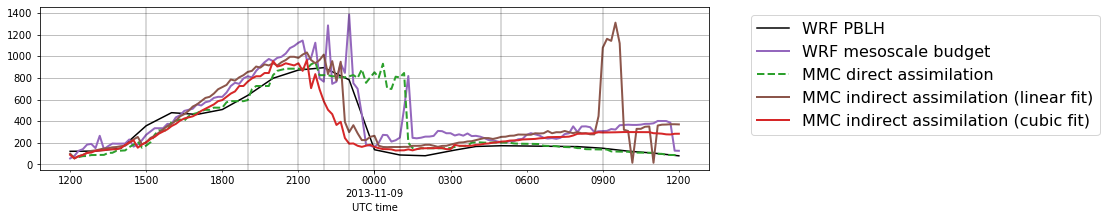

In [15]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(wrf_pblh.index, wrf_pblh, 'k', label='WRF PBLH')
plot_timehistory_at_height(ablh, datasetkwargs=styles,
                           fig=fig,ax=ax)
ax.grid(False,which='both')
ax.grid(True,axis='y')
for t in selected_times: 
    ax.axvline(t, color='k', alpha=0.2)
fig.savefig('ablh_comparison.png',bbox_inches='tight')

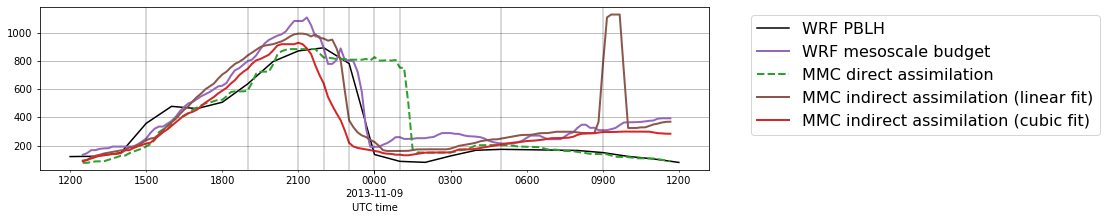

In [16]:
fig,ax = plt.subplots(figsize=(12,3))
ax.plot(wrf_pblh.index, wrf_pblh, 'k', label='WRF PBLH')
plot_timehistory_at_height(ablh_smoo, datasetkwargs=styles,
                           fig=fig,ax=ax)
ax.grid(False,which='both')
ax.grid(True,axis='y')
for t in selected_times: 
    ax.axvline(t, color='k', alpha=0.2)
fig.savefig('ablh_smoo_comparison.png',bbox_inches='tight')

### - profiles at selected times

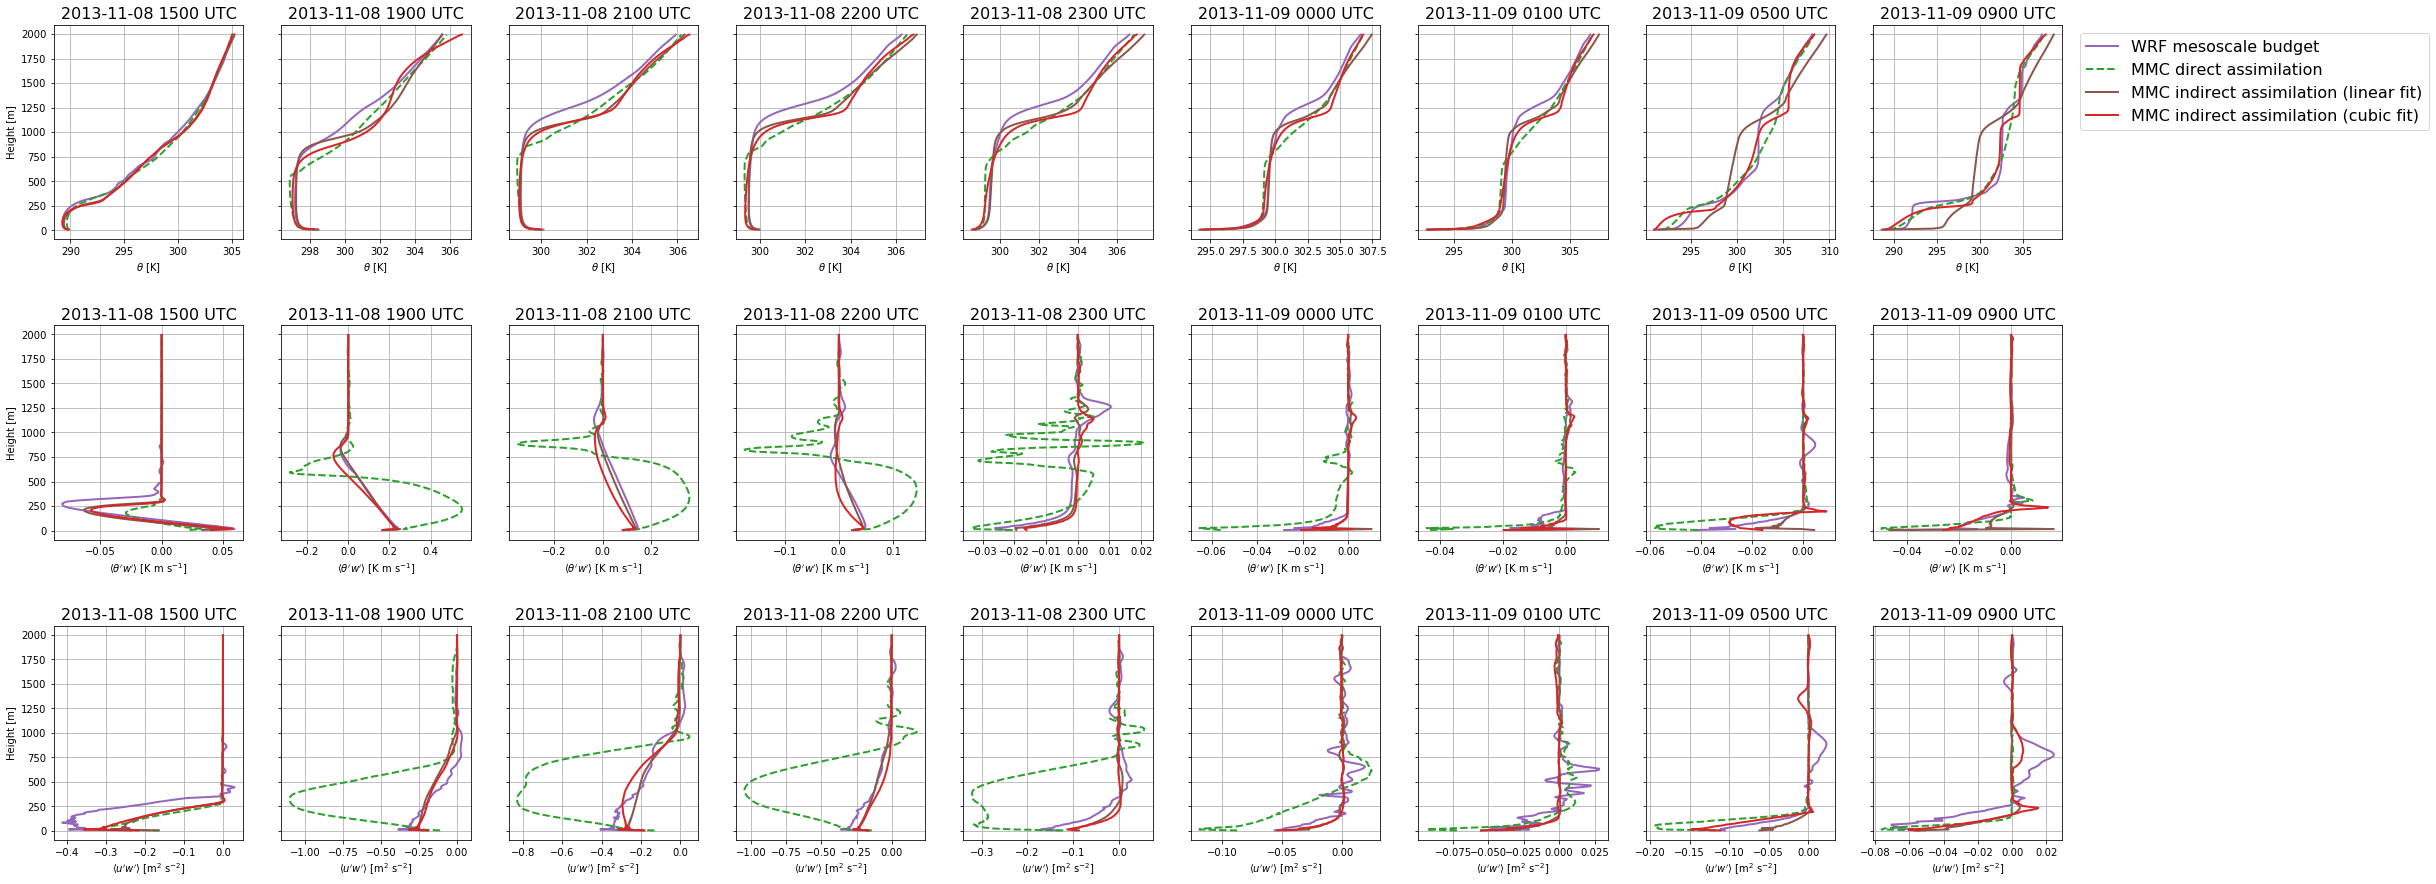

In [17]:
fig,ax = plot_profile(avg10, times=selected_times,
                      fields=['T','TUz','UUyz'],#'UUzz'],
                      fieldlabels={
                          'T': r"$\theta$ [K]",
                          'TUz': r"$\langle \theta'w' \rangle$ [K m s$^{-1}$]",
                          'UUyz': r"$\langle u'w' \rangle$ [m$^2$ s$^{-2}$]",
                          'UUzz': r"$\langle w'w' \rangle$ [m$^2$ s$^{-2}$]",
                      },
                      stack_by_datasets=True,
                      datasetkwargs=styles)
fig.savefig('profiles_comparison_all.png',bbox_inches='tight')

In [18]:
# for t in selected_times:
#     fig,ax = plot_profile(avg10, fields=['T','TUz','UUyz','UUzz'],
#                           fieldlabels={
#                               'T': r"$\theta$ [K]",
#                               'TUz': r"$\langle \theta'w' \rangle$ [K m s$^{-1}$]",
#                               'UUyz': r"$\langle u'w' \rangle$ [m$^2$ s$^{-2}$]",
#                               'UUzz': r"$\langle w'w' \rangle$ [m$^2$ s$^{-2}$]",
#                           },
#                           times=t, fieldorder='F',
#                           stack_by_datasets=True,
#                           datasetkwargs=styles)
#     fname = t.strftime('profiles_%Y%m%d_%H%M%S.png')
#     fig.savefig(fname,bbox_inches='tight')
#     print('Wrote',fname)